# 1. Required Modules

For proper reproducibility, here are the modules uses in this notebook.

In [1]:
# pip install toolz

In [2]:
# pip install altair

In [3]:
# pip install pandas

In [4]:
# Run this cell to ensure that altair plots show up without having
# the notebook be really large.
# We will talk more about what these lines do later in the course
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

# 2. Exploratory Data Analysis

In depth EDA can be found in each teammate's folder in the analysis directory. This file will be compiling the key findings of each group member.

## Load Dataset

In [5]:
mxmh_raw = pd.read_csv("../data/raw/mxmh_survey_results.csv")

Our original dataset had: 25 categorical attributes, 1 temporal attribute, 4 ordinal attributes, and 7 quantitative attributes.

To clean the data, we will use a combination of each group member's wrangling. The script can be found in the "scripts" folder. 

In [6]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head(5)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Anxiety_Level,Depression_Level,Insomnia_Level,OCD_Level,Date,Time,Time of Day,Musical_hobbies,Age_Grouped,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Low,Low,Low,Low,2022-08-27,19:29:02,Evening,Yes,18.0,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,High,Low,Low,Low,2022-08-27,19:57:31,Evening,No,63.0,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,High,High,High,Low,2022-08-27,21:28:18,Evening,No,18.0,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,High,High,Low,Low,2022-08-27,21:40:40,Evening,Yes,61.0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,High,Low,Medium,High,2022-08-27,21:54:47,Evening,No,18.0,10


## Key Observations: Cleaning

### NA's

In [7]:
na_counts_music = pd.DataFrame({
    "Column": mxmh_raw.columns,
    "Missing Values": [mxmh_raw[col].isna().sum() for col in mxmh_raw.columns]
})

na_counts_music["proportion"] = na_counts_music["Missing Values"]/len(mxmh_raw) * 100
na_counts_music = na_counts_music.round(2)
na_counts_music = na_counts_music.sort_values("proportion", ascending=False)
columns_with_nas = na_counts_music[na_counts_music["proportion"] > 0]
columns_with_nas

,Column,Missing Values,proportion
10,BPM,107,14.54
31,Music effects,8,1.09
9,Foreign languages,4,0.54
5,Instrumentalist,4,0.54
4,While working,3,0.41
2,Primary streaming service,1,0.14
6,Composer,1,0.14
1,Age,1,0.14


Our data had significant NA's. For general use, we filled BPM NA's using random sampling using probabilties of each value to avoid overrepresentation of rarer values. We filled the other NA's by setting the value to "Unknown" (categorical vars) or setting the value to the median (Age)

### Notable Outliers

In [8]:
sorted_bpm = mxmh_raw["BPM"].dropna().sort_values(ascending=True)

print("Lowest 10 BPM values:")
print(sorted_bpm.head(10))

print("\nHighest 10 BPM values:")
print(sorted_bpm.tail(10))

Lowest 10 BPM values:
339     0.0
639     0.0
524     0.0
429     4.0
567     8.0
372    20.0
421    40.0
214    52.0
427    55.0
58     55.0
Name: BPM, dtype: float64

Highest 10 BPM values:
296          200.0
498          204.0
353          208.0
564          210.0
711          210.0
662          218.0
610          220.0
248          220.0
644          624.0
568    999999999.0
Name: BPM, dtype: float64


BPM has very notable outliers, such as 999999999 and 0.

### Derived Values

Following all of our group members' individual EDAs, our datasat gained the following derived columns:
1. Anxiety_Level [Low, Medium, High]
2. Depression_Level [Low, Medium, High]
3. Insomnia_Level [Low, Medium, High]
4. OCD_Level [Low, Medium, High]
5. Date
6. Time
7. Time of Day [Morning, Afternoon, Evening, Night]
8. Musical_hobbies [Yes, No]
9. Age_Grouped (10, 66)
10. Genre Diversity Score

We dropped the Permissions column

## Key Findings

### Univariate Analysis

#### Quantitative variables

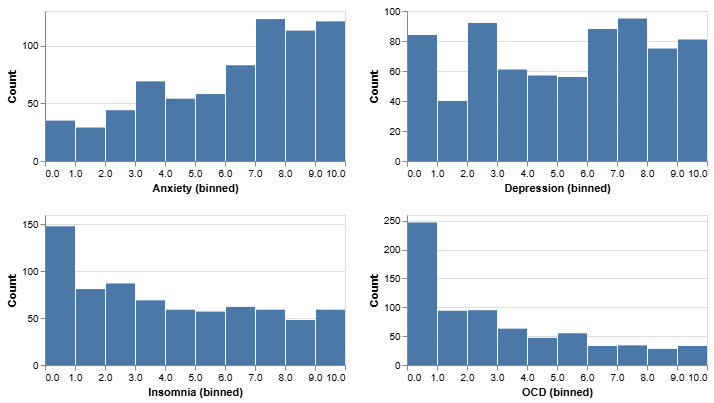

In [9]:
mho_distributions = alt.Chart(mxmh).mark_bar().encode(
                     alt.X(alt.repeat(), bin=alt.BinParams(maxbins=15), type = 'quantitative'),
                    alt.Y('count():Q', title='Count')
                    ).properties(height=150).repeat(['Anxiety', 'Depression', 'Insomnia', 'OCD'], columns=2)
mho_distributions

We can see the shape of the data for each of the mental health outcomes. It seems like none of them follow a Normal distribution. 
- Anxiety: The histogram shows that the data is somewhat left-skewed, indicating that many people experience higher levels of anxiety.
- Depression: The histogram shows two peaks (one from 0-3.0) and the other at (6.0-7.0).
- Insomnia: The histogram shows that the data is more right-skewed, indicating that more people experience lower levels of insomnia, with a peak at 0.
- OCD: The histogram shows that the data is more right-skewed, indicating that more people experience lower levels of OCD, with a peak at 0.

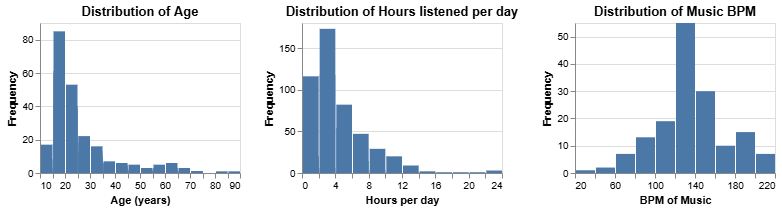

In [10]:
hist_age = alt.Chart(mxmh).mark_bar().encode(
    alt.X("Age:Q", bin=alt.Bin(maxbins=20), title="Age (years)"),
    alt.Y('count()', title="Frequency"),
    tooltip = ["Age", "count()"]
).properties(
    width=200,
    height=150,
    title="Distribution of Age"
)
hist_hours = alt.Chart(mxmh).mark_bar().encode(
    alt.X("Hours per day:Q", bin=alt.Bin(maxbins=15), title="Hours per day"),
    alt.Y('count()', title="Frequency"),
    tooltip = ["Hours per day", "count()"]
).properties(
    width=200,
    height=150,
    title="Distribution of Hours listened per day"
)
hist_bpm = alt.Chart(mxmh).mark_bar().encode(
    alt.X("BPM:Q", bin=alt.Bin(maxbins=15), title="BPM of Music"),
    alt.Y('count()', title="Frequency"),
    tooltip = ["BPM", "count()"]
).properties(
    width=200,
    height=150,
    title="Distribution of Music BPM"
)

hist_age | hist_hours | hist_bpm

Based on the plots:
- Respondant age skews younger, which is unsurprising considering that the survey was published using online forums and social media sites.
- Distribution of hours listened per day is skewed towards 0-8 hours, with a three people listening 24 hours a day.
- BPM, now that it has been cleaned and sliced, displays a tendency for individuals to listen to music around 120 bpm. 

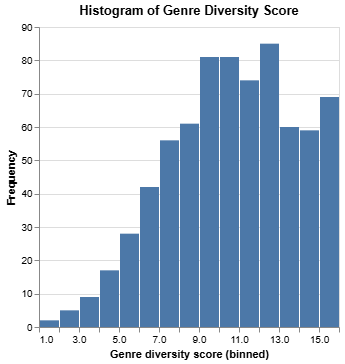

In [16]:
gds_distribution = alt.Chart(mxmh).mark_bar().encode(
                     alt.X('Genre Diversity Score:Q',  bin=alt.BinParams(maxbins=15), title='Genre diversity score (binned)'),
                    alt.Y('count():Q', title='Frequency')
                    ).properties(title='Histogram of Genre Diversity Score')
gds_distribution

By looking at the histogram of genre distribution, I notice that the distribution of 'Genre Diversity Score' is somewhat unimodal and slightly left-skewed, with a peak around 9-11. There is a gradual increase in frequency from the lower scores towards the peak, followed by a sharper drop-off on the right side, suggesting that very high genre diversity scores are less common than moderate to high scores. Additionally, there are relatively few scores below 5, implying that very low genre diversity is less common.

#### Categorical Variables

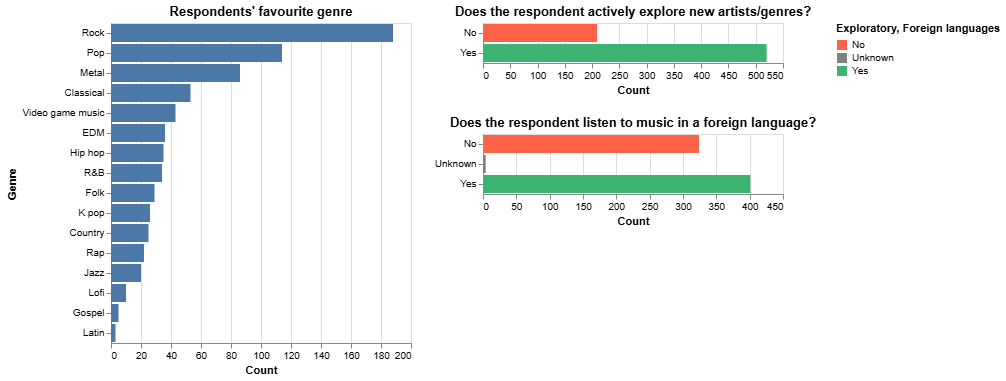

In [14]:
genre_dist = alt.Chart(mxmh).mark_bar().encode(
            alt.Y('Fav genre', sort="-x", title='Genre'),
            alt.X('count()', title='Count')
).properties(title="Respondents' favourite genre")

explore_dist = alt.Chart(mxmh).mark_bar().encode(
    alt.Y('Exploratory', title=""),
    alt.X('count()', title='Count'),
    alt.Color('Exploratory', scale=alt.Scale(range=colors))
).properties(
    title='Does the respondent actively explore new artists/genres?'
)

foreign_lang_dist = alt.Chart(mxmh).mark_bar().encode(
    alt.Y('Foreign languages', title=""),
    alt.X('count()', title='Count'),
    alt.Color('Foreign languages', scale=alt.Scale(range=colors))
).properties(
    title='Does the respondent listen to music in a foreign language?'
)

genre_dist | explore_dist & foreign_lang_dist

Rock, Pop and Metal are the most frequently listened to genres. Most respondents explore new genres and a little over half listen to msic they are not fluent in.

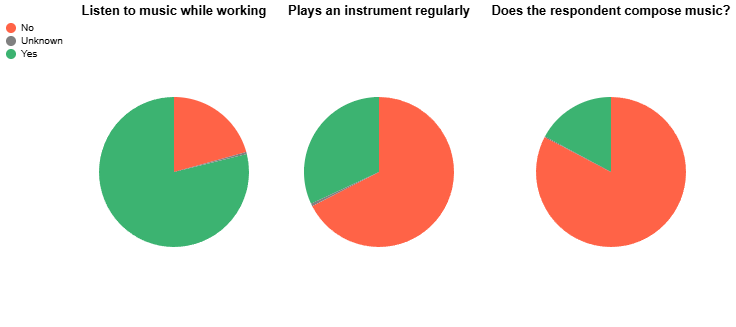

In [12]:
colors = ['tomato', 'grey', 'mediumseagreen']

work_pie = alt.Chart(mxmh).mark_arc().encode(
            alt.Color('While working', title='Listens While Working', scale=alt.Scale(range=colors)).legend(orient="left", title=None),
            alt.Theta('count()', title='Count')
).properties(
    title='Listen to music while working',
    width=150
)

instru_pie = alt.Chart(mxmh).mark_arc().encode(
            alt.Color('Instrumentalist', title='Plays an Instrument', scale=alt.Scale(range=colors)),
            alt.Theta('count()', title='Count')
).properties(
    title='Plays an instrument regularly',
    width=150)

composer_pie = alt.Chart(mxmh).mark_arc().encode(
            alt.Color('Composer', title='Composes Music', scale=alt.Scale(range=colors)),
            alt.Theta('count()', title='Count')
).properties(title='Does the respondent compose music?',
    width=150)
alt.hconcat(work_pie, instru_pie, composer_pie)

Seems like most respondents listen to music while working, but most do not play an instrument and even more do not compose their own music.

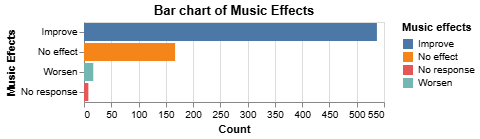

In [15]:
music_effects_dist = alt.Chart(mxmh).mark_bar().encode(
            alt.Y('Music effects', sort="-x", title='Music Efects'),
            alt.X('count()', title='Count'),
    alt.Color("Music effects")
).properties(title='Bar chart of Music Effects')
music_effects_dist

Seems like most people think music improves mental health!

### Bivariate Analysis

We've included a few visualizations from each of our individual EDA to demonstrate key findings.

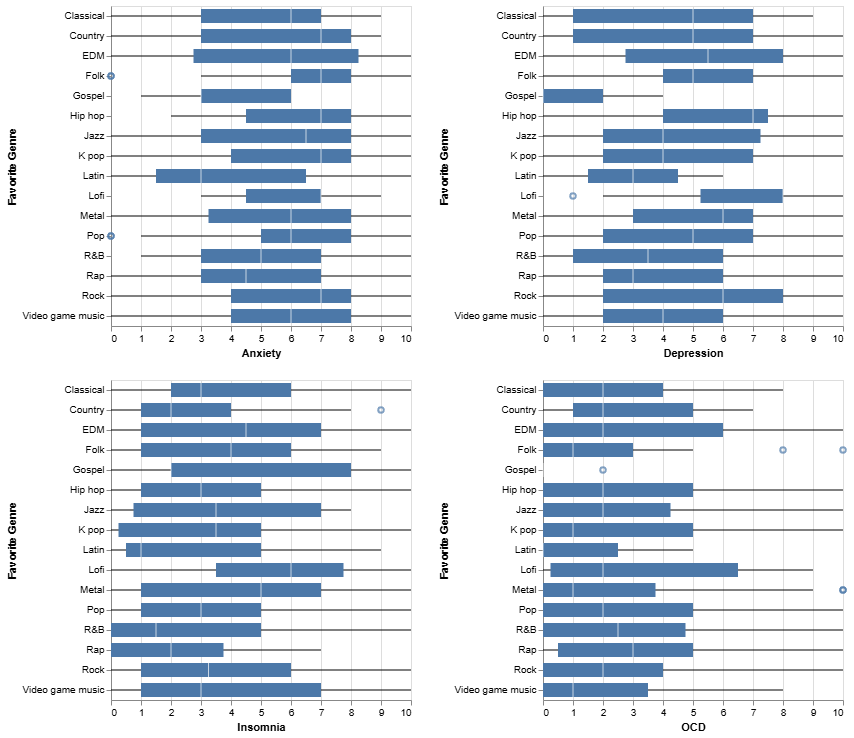

In [13]:
mho_genres_boxplot = alt.Chart(mxmh).mark_boxplot().encode(
                     alt.X(alt.repeat(), type='quantitative'),
                    alt.Y('Fav genre', title='Favorite Genre', sort='x')
                    ).repeat(['Anxiety', 'Depression', 'Insomnia', 'OCD'], columns=2)
mho_genres_boxplot

- Anxiety: We can see a high median of 8 for Folk music, which suggests that on average, individuals who prefer Folk music have the highest self-reported anxiety score, followed by Rock, Lofi, Kpop, and Hip Hop with a median of 7. The preferred genre that shows the lowest median anxiety scores are Rap and Gospel.

- Depression: We can see a high median of 8 for Lofi music, which suggests that on average, individuals who prefer Lofi music have the highest self-reported depression score, and Gospel has a median of 1, which shows the lowest median depression score.

- Insomnia: The median scores for insomnia were overall less than the anxiety and depression ones. We can see a high median of 6 for Lofi music, which suggests that on average, individuals who prefer Lofi music have the highest self-reported insomnia score, and R&B has a median of 1, which shows the lowest median insomnia score.

- OCD: The median scores for insomnia were overall even less than all the other ones. We can see a median of 2.5 for Latin music, which suggests that, on average, individuals who prefer Latin music have the highest self-reported OCD score, and Metal and Kpop have a median of 1, which shows the lowest median OCD scores. 

In summary, the graphs show the distribution of mental health condition scores for each favorite music genre. There are differences in the distribution, median, spread, and outliers across genres, suggesting potential associations between favorite music genres and mental health conditions. 

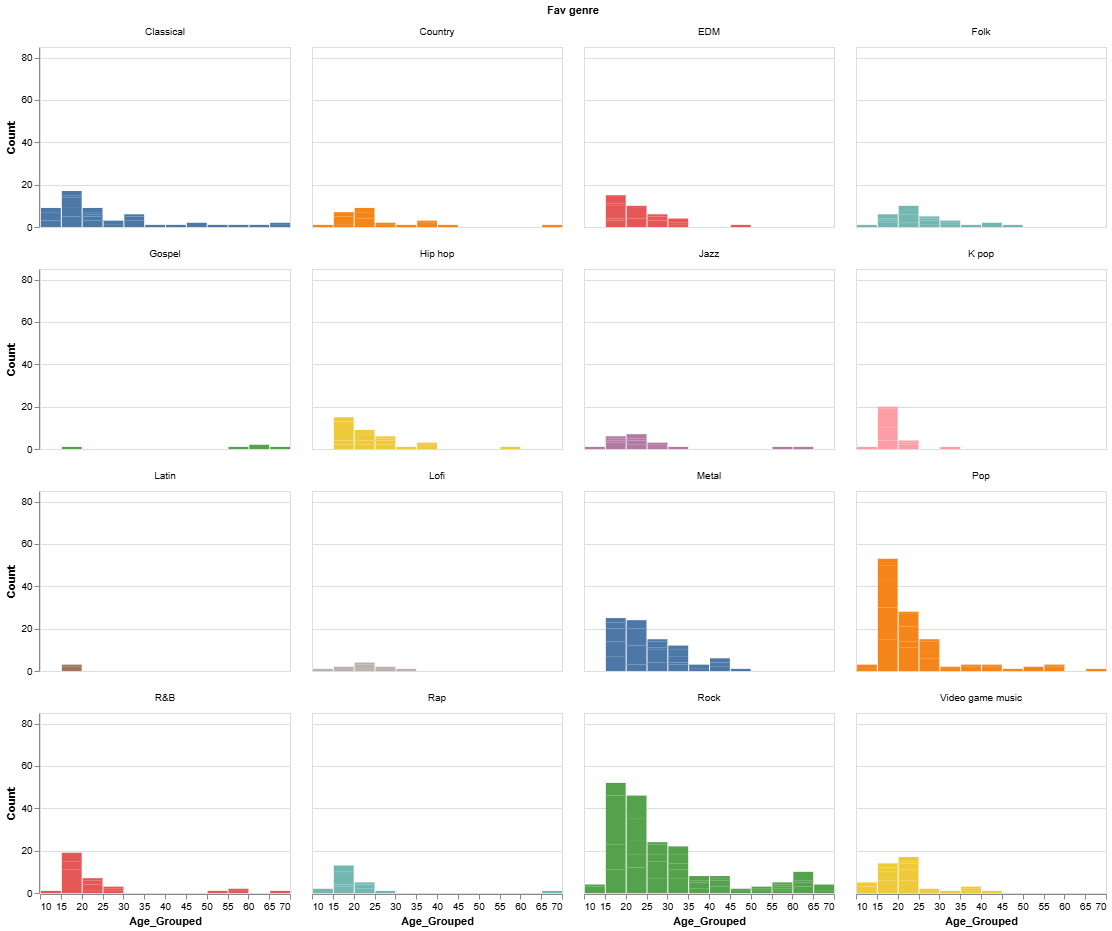

In [20]:
min_age = int(mxmh["Age_Grouped"].min())
max_age = int(mxmh["Age_Grouped"].max() + 4)
max_y = mxmh.groupby("Age_Grouped")["Fav genre"].count().max()


age_genre_hist = alt.Chart(mxmh).mark_bar().encode(
    alt.X("Age_Grouped:Q", bin=alt.Bin(step=5), title="Age_Grouped",
          
          scale=alt.Scale(domain=[min_age, max_age])),
    alt.Y("count()", title="Count",
          scale=alt.Scale(domain=[0, max_y])),
    alt.Color("Fav genre:N", legend=None),
    tooltip=["Age", "Fav genre", "count()"]
).properties(
    width=250,
    height=180
).facet(
    "Fav genre",
    columns=4
)

age_genre_hist

From this plot:
- The favourite genre of each age group most closely resembles the distribution of age
- Rock displays two (albeit one significantly smaller) peaks at 15-20 years and 60-65
- Video game, Lofi and Kpop are often preferred by younger respondants.
- Gospel is predominately preferred by older respondants.

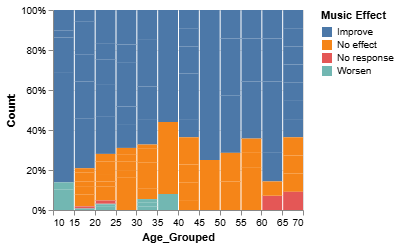

In [19]:
min_age = int(mxmh["Age_Grouped"].min())
max_age = int(mxmh["Age_Grouped"].max() + 4)

music_outcome = alt.Chart(mxmh).mark_bar().encode(
         alt.X("Age_Grouped:Q", bin=alt.Bin(step=5), title="Age_Grouped",
              axis=alt.Axis(values=list(range(min_age, max_age+5, 5))),
              scale=alt.Scale(domain=[min_age, max_age])),
        alt.Y("count()", title="Count", stack="normalize"),
        alt.Color("Music effects", type="nominal", title="Music Effect"),
        tooltip=["Age", "Music effects", "count()"]
    ).properties(
        width=250,
        height=200
    )
music_outcome

From this chart, we can observe:

- Most individuals, regardless of age, report improvement of mental health.
- There is a peak of respondants stating that music has no effect for ages 35-40 and older ages
- The greatest within-age-group proportion of individuals who reported worsening effects from music are in the age group 10-15